In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Medicalpremium.csv') #read csv file

# EDA
## 檢視表格資料及空值檢查

In [ ]:
df.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000


## 各欄位介紹 (1:有, 0:無)
---
Age ：年齡  
Diabetes : 是否患有糖尿病  
BloodPressureProblems : 是否血壓有異常問題  
AnyTransplants : 是否經歷過主要器官移植手術  
AnyChronicDiseases : 是否患有哮喘等慢性疾病  
Height : 身高,	Weight : 體重  
KnownAllergies : 是否有任何已知的過敏症  
HistoryOfCancerInFamily : 任何血緣親屬是否患有任何形式的癌症   
NumberOfMajorSurgeries : 該人接受過的大手術次數  
PremiumPrice : 年保費價格  
  


---


In [ ]:
df.isnull().sum()

Age                        0
Diabetes                   0
BloodPressureProblems      0
AnyTransplants             0
AnyChronicDiseases         0
Height                     0
Weight                     0
KnownAllergies             0
HistoryOfCancerInFamily    0
NumberOfMajorSurgeries     0
PremiumPrice               0
dtype: int64

In [ ]:
df.describe()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
count,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000
mean,41.745436,0.419878,0.468560,0.055781,0.180527,168.182556,76.950304,0.215010,0.117647,0.667343,24336.713996
std,13.963371,0.493789,0.499264,0.229615,0.384821,10.098155,14.265096,0.411038,0.322353,0.749205,6248.184382
min,18.000000,0.000000,0.000000,0.000000,0.000000,145.000000,51.000000,0.000000,0.000000,0.000000,15000.000000
25%,30.000000,0.000000,0.000000,0.000000,0.000000,161.000000,67.000000,0.000000,0.000000,0.000000,21000.000000
50%,42.000000,0.000000,0.000000,0.000000,0.000000,168.000000,75.000000,0.000000,0.000000,1.000000,23000.000000
75%,53.000000,1.000000,1.000000,0.000000,0.000000,176.000000,87.000000,0.000000,0.000000,1.000000,28000.000000
max,66.000000,1.000000,1.000000,1.000000,1.000000,188.000000,132.000000,1.000000,1.000000,3.000000,40000.000000


新增BMI欄位

In [ ]:
#compute BMI
df["bmi"] = df.Weight/(df.Height/100)**2
df["bmi"] = pd.to_numeric(pd.cut(df['bmi'], bins=[0,24,27,30,35,100], labels=[0,1,2,3,4]))

# 檢視PremiumPrice分布

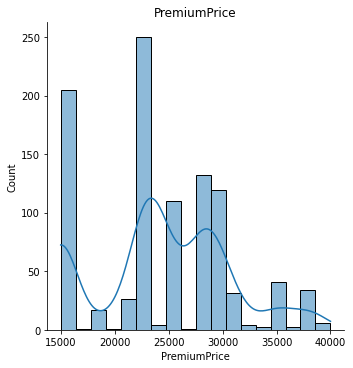

In [ ]:
sns.displot(df.PremiumPrice, kde=True)
plt.title("PremiumPrice")
plt.show()

## 畫出個欄位的Correlation heap map

Text(0.5, 1.0, 'Correlation Heatmap')

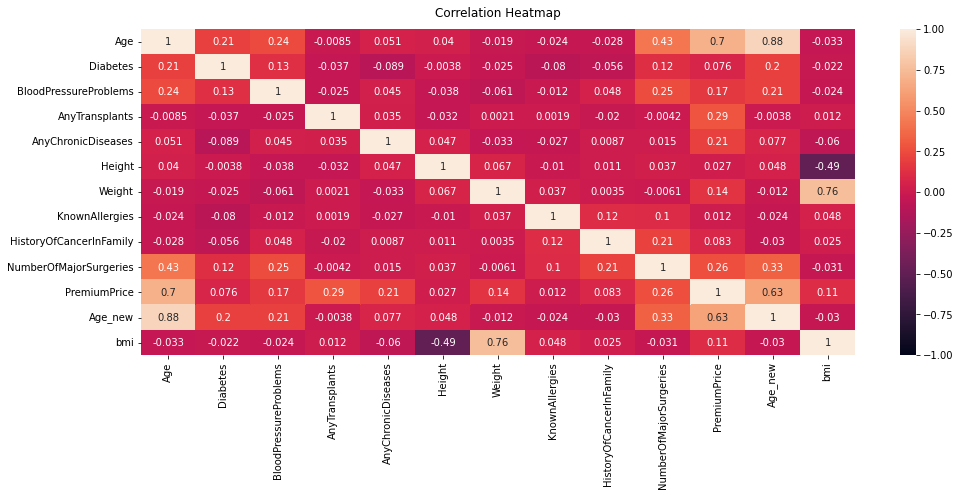

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

根據Correlation heap map 的圖表，選出與PremiumPrice相關性大於0.2之欄位做EDA  
(Age, AnyTransplants, AnyChronicDiseases, NumberOfMajorSurgeries)

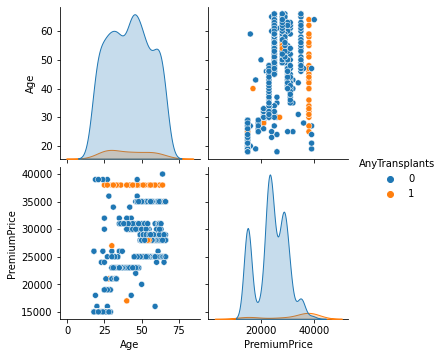

In [ ]:
sns.pairplot(df, vars = ["Age", "PremiumPrice"], hue = "AnyTransplants")
plt.show()

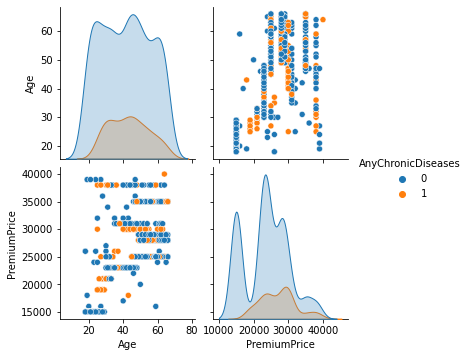

In [ ]:
sns.pairplot(df, vars = ["Age", "PremiumPrice"], hue = "AnyChronicDiseases")
plt.show()

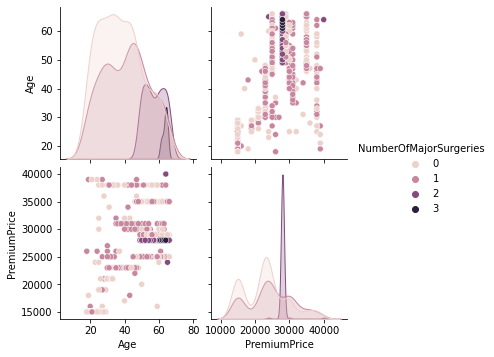

In [ ]:
sns.pairplot(df, vars = ["Age", "PremiumPrice"], hue = "NumberOfMajorSurgeries")
plt.show()

畫出三個連續性欄位的關聯分布及對應的PremiumPrice label

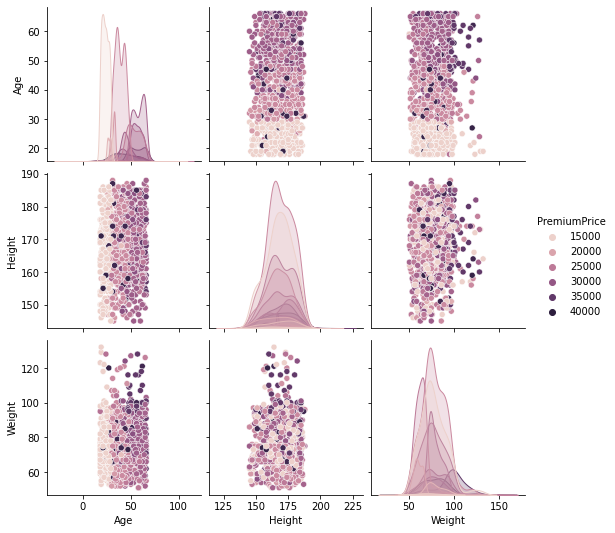

In [ ]:
sns.pairplot(df, vars = ["Age", "Height", "Weight"], hue = "PremiumPrice")
plt.show()

由上述之EDA可看出，

*   年齡是影響PremiumPrice的主要因子, 但身高及體重似乎較無關聯
*   是否經歷過主要器官移植手術也會使得PremiumPrice需要付出相當大的金額
*   該人接受過的大手術次數與PremiumPrice有明顯的分布差異
---



由於年齡與PremiumPrice高度相關，在這邊再創一個欄位代表幼年、青年、壯年、老年，以增加模型對於年齡的權重。

In [ ]:
df["Age_new"]=pd.to_numeric(pd.cut(df["Age"],bins=[0,20,40,65,100], labels = [0,1,2,3]))

# Model select & training
## 1.選擇模型

In [ ]:
from sklearn.linear_model import Ridge,Lasso,LinearRegression
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV,RepeatedStratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import explained_variance_score

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
PremiumPrice = labelencoder.fit_transform(df.PremiumPrice)
df_x = df.drop(columns = ["PremiumPrice"])
xtr,xte,ytr,yte=train_test_split(df_x,PremiumPrice,random_state=33,test_size=0.2, shuffle = True)


In [ ]:
models=[('KNN',KNeighborsClassifier()),('DT',DecisionTreeClassifier()),('RF',RandomForestClassifier()),('AdaBoost',AdaBoostClassifier())
        ,('GP',GaussianProcessClassifier()),('NB',GaussianNB()),('XGB',XGBClassifier())]
scores=[]

for name,model in models:
    model.fit(xtr,ytr)
    preds=model.predict(xte)
    score=explained_variance_score(preds,yte)
    scores.append([name,model,score])

In [ ]:
scores_df=pd.DataFrame(scores,columns=['Name','Model','Score'])
scores_df.sort_values('Score',ascending=False)

,Name,Model,Score
2,RF,"(DecisionTreeClassifier(max_features='auto', r...",0.872457
6,XGB,XGBClassifier(objective='multi:softprob'),0.825311
1,DT,DecisionTreeClassifier(),0.613664
0,KNN,KNeighborsClassifier(),0.503548
4,GP,GaussianProcessClassifier(),0.479142
5,NB,GaussianNB(),-2.088827
3,AdaBoost,"(DecisionTreeClassifier(max_depth=1, random_st...",-28.697593


由上表選定最高的explained_variance_score為RandomForest model,因此選定為模型進行grid search最佳化參數

In [ ]:

from sklearn.model_selection import GridSearchCV
classfier=RandomForestClassifier (n_jobs=-1,verbose=2)
param_grid={'n_estimators':[500,300,100],
            'max_depth':[7,8,9,10],
            'min_samples_split':[3,4,5],
            'max_features':['auto']}
gs=GridSearchCV(classfier,param_grid=param_grid,cv=3,n_jobs=-1,verbose=1)
gs.fit(xtr,ytr)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  UserWarning,
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.1s


building tree 1 of 300
building tree 2 of 300
building tree 3 of 300building tree 4 of 300

building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300building tree 14 of 300

building tree 15 of 300building tree 16 of 300

building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
b

[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    0.4s


building tree 236 of 300
building tree 237 of 300
building tree 238 of 300
building tree 239 of 300building tree 240 of 300

building tree 241 of 300
building tree 242 of 300
building tree 243 of 300
building tree 244 of 300
building tree 245 of 300
building tree 246 of 300
building tree 247 of 300
building tree 248 of 300
building tree 249 of 300
building tree 250 of 300
building tree 251 of 300building tree 252 of 300

building tree 253 of 300
building tree 254 of 300building tree 255 of 300

building tree 256 of 300
building tree 257 of 300
building tree 258 of 300building tree 259 of 300

building tree 260 of 300
building tree 261 of 300
building tree 262 of 300
building tree 263 of 300
building tree 264 of 300
building tree 265 of 300
building tree 266 of 300
building tree 267 of 300
building tree 268 of 300
building tree 269 of 300
building tree 270 of 300
building tree 271 of 300building tree 272 of 300

building tree 273 of 300
building tree 274 of 300
building tree 275 of 300b

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    0.8s finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, verbose=2),
             n_jobs=-1,
             param_grid={'max_depth': [7, 8, 9, 10], 'max_features': ['auto'],
                         'min_samples_split': [3, 4, 5],
                         'n_estimators': [500, 300, 100]},
             verbose=1)

In [ ]:
pre = gs.predict(xte)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.1s finished


In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(pre, yte)
print(f"best accuracy(RandomForest model) = {accuracy:2.2f}")

best accuracy(RandomForest model) = 0.91


最後RandomForest之Accuracy高達0.91

In [ ]:
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder()
PremiumPrice = labelencoder.fit_transform(df.PremiumPrice)
PremiumPrice=onehotencoder.fit_transform(np.array(PremiumPrice).reshape(-1, 1)).toarray()
xtr_dnn,xte_dnn,ytr_dnn,yte_dnn=train_test_split(df_x,PremiumPrice,random_state=33,test_size=0.2, shuffle = True)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath = "/content/drive/MyDrive/Colab Notebooks/best.hdf5"
model = Sequential()
# Add Input layer, 隱藏層(hidden layer) 有 256個輸出變數
#model.add(Dense(units=512, input_dim=xtr_dnn.shape[1], kernel_initializer='normal', activation='relu')) 
model.add(Dense(units=128, input_dim=xtr_dnn.shape[1], kernel_initializer='normal', activation='relu')) 
# Add output layer
model.add(Dense(units=32, kernel_initializer='normal', activation='relu'))
#model.add(Dense(units=8, kernel_initializer='normal', activation='relu'))
model.add(Dense(units=ytr_dnn.shape[1], kernel_initializer='normal',activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam" , metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
earlystopper = EarlyStopping(monitor='val_accuracy', patience=2000, verbose=1)
callbacks_list = [checkpoint, earlystopper]

In [ ]:
model.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_136 (Dense)           (None, 128)               1664      
                                                                 
 dense_137 (Dense)           (None, 32)                4128      
                                                                 
 dense_138 (Dense)           (None, 24)                792       
                                                                 
Total params: 6,584
Trainable params: 6,584
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_history = model.fit(x=xtr_dnn, y=ytr_dnn, validation_split=0.3, epochs=10000, batch_size=800, verbose=2, shuffle=True, callbacks=callbacks_list)

串流輸出內容已截斷至最後 5000 行。

Epoch 01817: accuracy did not improve from 0.91833
1/1 - 0s - loss: 0.3335 - accuracy: 0.9147 - val_loss: 1.3635 - val_accuracy: 0.7975 - 42ms/epoch - 42ms/step
Epoch 1818/10000

Epoch 01818: accuracy did not improve from 0.91833
1/1 - 0s - loss: 0.3334 - accuracy: 0.9147 - val_loss: 1.3663 - val_accuracy: 0.7975 - 45ms/epoch - 45ms/step
Epoch 1819/10000

Epoch 01819: accuracy did not improve from 0.91833
1/1 - 0s - loss: 0.3333 - accuracy: 0.9129 - val_loss: 1.3622 - val_accuracy: 0.7932 - 50ms/epoch - 50ms/step
Epoch 1820/10000

Epoch 01820: accuracy did not improve from 0.91833
1/1 - 0s - loss: 0.3333 - accuracy: 0.9165 - val_loss: 1.3672 - val_accuracy: 0.8017 - 38ms/epoch - 38ms/step
Epoch 1821/10000

Epoch 01821: accuracy did not improve from 0.91833
1/1 - 0s - loss: 0.3333 - accuracy: 0.9111 - val_loss: 1.3626 - val_accuracy: 0.7890 - 33ms/epoch - 33ms/step
Epoch 1822/10000

Epoch 01822: accuracy did not improve from 0.91833
1/1 - 0s - loss: 0.3331 - accura

In [ ]:
pre_dnn = model.predict(xte_dnn)
p = np.argmax(pre_dnn, axis=-1)
y = np.argmax(yte_dnn, axis=-1)
accuracy = accuracy_score(p, y)
print(f"best accuracy(DNN model) = {accuracy:2.2f}")

best accuracy(DNN model) = 0.80


建立DNN model嘗試與RandomForest model進行比較，但結果較差，且訓練效能也相當差

In [ ]:
import joblib

joblib.dump(gs, "/content/drive/MyDrive/Colab Notebooks/random_forest.joblib")

['/content/drive/MyDrive/Colab Notebooks/random_forest.joblib']

In [ ]:
loaded_rf = joblib.load("/content/drive/MyDrive/Colab Notebooks/random_forest.joblib")

In [ ]:
xte_dnn

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,bmi,Age_new
110,55,0,1,0,0,159,91,1,0,1,4,2
701,49,1,1,0,1,164,60,0,0,2,0,2
287,52,0,0,0,0,180,57,0,0,1,0,2
450,20,1,0,0,0,181,77,1,1,1,0,0
434,50,1,0,0,0,164,73,1,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...
558,42,1,1,0,0,185,96,0,0,1,2,2
321,33,0,0,0,0,177,97,0,0,0,3,1
437,37,0,0,0,1,170,52,1,0,0,0,1
256,20,0,0,0,0,166,75,0,0,0,2,0
